1. Load real data
2. Get dict for every sample and protein with peptide:abundance
3. Compute disassembly, save in dict ```results[sample][protein]```

In [1]:
import pandas as pd

data = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/data.csv"
)
design = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/design.csv"
)
proteome = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/sus_scrofa.gz",
    sep="\t",
)
design = design[design["day"] == "Day 1"]
design = design[design["group"].isin(["P. aeruginosa", "S. aureus", "Ctrl"])]
data.head()

,Protein,Peptide,Start,End,Mods,Sample 17 Day 1,Sample 18 Day 1,Sample 19 Day 1,Sample 20 Day 1,Sample 21 Day 1,...,Sample 57 Day 3,Sample 6 Day 1,Sample 7 Day 1,Sample 8 Day 1,Sample 9 Day 1,Sample 6 Day 2,Sample 7 Day 2,Sample 8 Day 2,Sample 9 Day 2,id
0,F1RX36,EVQDKGEFLAEGGGV,48,62,|,19.027615,19.382448,19.961013,21.187212,21.368261,...,21.033294,21.174478,20.748411,20.302304,19.214573,21.597742,20.836507,20.925307,18.585502,0
1,F1RX36,TQARETPPEWKALLETRQV,267,285,|,9.865061,8.239543,NaN,10.576868,11.717915,...,15.099619,14.430800,12.746662,13.029899,13.513466,15.524457,13.921798,13.648346,NaN,1
2,F1RX36,AEVQDKGEFLAEGGGV,47,62,|,17.218737,17.385290,17.685324,18.457380,18.683422,...,17.975231,18.464215,18.031206,15.622869,14.767041,16.725992,16.181084,17.384373,14.583107,2
3,F1RX36,VQDKGEFLAEGGGV,49,62,|,18.036758,18.311151,18.354891,17.804428,19.686764,...,19.138828,18.747020,18.025790,15.337530,13.093820,18.733983,17.971121,18.258311,15.906347,3
4,F1RX36,EVQDKGEFLAEGGGVR,48,63,|,19.610232,18.691592,19.474747,20.322715,19.572983,...,20.906823,20.271821,19.153869,20.270388,19.101946,18.723957,20.401157,17.591283,16.817444,4


In [2]:
# Prepares data

proteins = ["F1RX36", "F1RX37", "HBA", "HBB", "APOA1", "APOC3", "ACTB", "PR39", "THRB", "ALBU"]

data = data[data["Protein"].isin(proteins)]
samples = design["sample"]
data_dict = {}

for sample in samples:
    sample_data = data[["Protein", "Peptide", sample]].dropna(subset=[sample])
    protein_dict = {}
    for protein in sample_data["Protein"].unique():
        protein_data = sample_data[sample_data["Protein"] == protein]
        peptide_dict = {}
        # insert the original protein sequence
        protein_sequence = proteome[
            proteome["Entry Name"].isin([f"{protein}_PIG", protein])
        ]["Sequence"].values[0]
        peptide_dict[protein_sequence] = (
            1  # probably want to replace this with some reasonable number
        )
        for i, row in protein_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'Sample 1 Day 1': {'F1RX36': {'MGWDVAAETILSSSRSAPPERAPPLAKMFSVRLFCLVLTVVGTVQMAEVQDKGEFLAEGGGVRGPRLTERHQSACKESDWPFCSDEDWNIKCPSGCRMKGLIDEVNQDFTNRINKLKNSLFDYQKNNKDSSTLSRNIIELLRGDFSNANNNDNIYSQVSEELRSRIEILKRKVLEKVQHIHLLQKNVRDQLIEMKRLEVDIDIKIRSCKGSCSRALEHKVDLKDYENQQKQLDQVIAINLLPSRDRQYLPLIKISPLPDITPADFKTQARETPPEWKALLETRQVKMVLERVGGDERTRGGSISHGPGSVPGTGSPGGLKPGSYGPGGPGTWKPGRPEPGSTGTWDSGHPDPGSAGTWKPGRPEPGSTGTWDSGHPDPGSAGTWKPGRPEPGSTGTWDSGRPDPGSAGTWKPGRPESGSTGTWHSEHLEHGSSSTWHSGQHEHGSVGSWKPGSSGSGSLRPDSSGPGDTTPSNPDWGTFKEVSGSVSPGTKSEVHTSKLVTSKGDKDIVIGKEKVTSGHTSTTHRSCSKTITKTVTKADGRTETIKEVINSEDGSDCGGTDVEFAHMLPGKGSLDEFFHRHRDETSLSRDPFPDFFSPVLKEFDGKTHPGGPGSDLAGFFHPDGPEYSSSSKISSHSKQTITKTINREGGAVESKSYKMEDEADSEEGLDLKGGHVIKRVYTRTRPARDCGDALQTHPSGAQSGIFNIELPGSSKIFSVYCDQETDLGGWLLIQQRTDGSLNFNRTWQDYKRGFGSLNDKGEGEFWLGNEYLHLLTLRGSVLRVELEDWAGKGAYAEYHLRVGSEAEGYALQVSSYKGTAGDALIEGSPEEGSEYTSHAGMQFSTFDRDADKWEENCAEVYGGGWWYNNCQAANLNGIYYTGGSYDPRDNSPYEIENGVVWVPFRGADYSLRAVRMKIRPLVTP': 10,
   'EVQDKGEFLAEGGGV': 21.626842338229

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


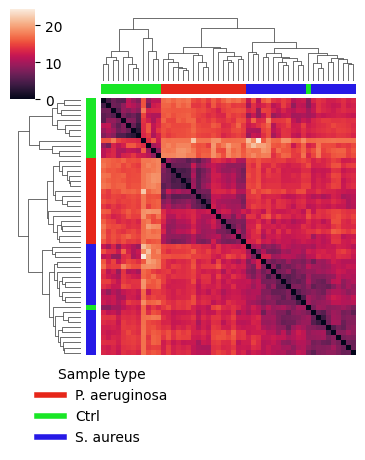

In [3]:
from disassembly.util import KL, normalize_dict
from disassembly.estimate_parameters import compare

# data_dict  sample:protein:peptides

protein = "APOA1"

comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

import seaborn as sns
from matplotlib.lines import Line2D

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)

g = sns.clustermap(
    comps_df,
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l) for l, c in zip(lut.keys(), lut.values())
]
g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [4]:
from disassembly.estimate_weights_gd import WeightEstimatorGD
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

results = {}  # dict of sample: protein_disassembly
wegd = WeightEstimatorGD(lr=1, n_iterations=250, lam=0.01)

for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    protein_disassembly = {}  # dict of protein: disassembly
    for protein, peptidome in protein_dict.items():
        graph = wegd.run(peptidome, verbose=True)
        di = get_disassembly_indexes_mc(graph, N_particles=10000)
        disassembly = get_disassembly(peptidome, di)
        protein_disassembly[protein] = disassembly
    results[sample] = protein_disassembly


 ---Sample 1 Day 1--- 

 249 / 250 | 3.58, kl: 3.42, reg: 0.15  | nz: 1236 | 
 Averaged DI: 2.51
 249 / 250 | 0.06, kl: 0.02, reg: 0.04  | nz: 517 | 
 Averaged DI: 2.52
 249 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 196 | 
 Averaged DI: 2.36
 236 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 97 |  
 Averaged DI: 1.73
 147 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 77 | 
 Averaged DI: 1.70
 187 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 49 | 
 Averaged DI: 1.71
 46 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 48 | 
 Averaged DI: 1.69
 34 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 13 | 
 Averaged DI: 1.14
 14 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 4 | 
 Averaged DI: 0.92

 ---Sample 2 Day 1--- 

 249 / 250 | 2.71, kl: 2.51, reg: 0.21  | nz: 2093 | 
 Averaged DI: 2.71
 249 / 250 | 0.03, kl: 0.01, reg: 0.02  | nz: 213 | 
 Averaged DI: 2.11
 249 / 250 | 0.04, kl: 0.01, reg: 0.02  | nz: 460 | 
 Averaged DI: 2.62
 134 / 250 | 0.01, kl: 0.00, reg: 0.01  | nz: 34 | 
 Averaged DI: 1.51
 249 / 250 | 0.02, kl:

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)

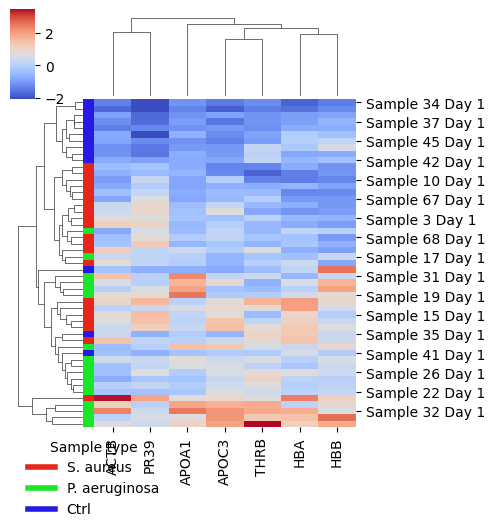

In [ ]:
import seaborn as sns
import numpy as np

g = sns.clustermap(
    results_df.replace(np.nan, 0).T,
    cmap="coolwarm",
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    z_score=True,
)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [ ]:
plot_df = results_df.T.stack().reset_index().rename(columns={"level_0":"sample","level_1":"protein",0:"amount"})


,sample,protein,amount,Unnamed: 0,group,day,id
0,Sample 1 Day 1,HBA,19.938440,0,S. aureus,Day 1,1
1,Sample 1 Day 1,APOC3,13.604375,0,S. aureus,Day 1,1
2,Sample 1 Day 1,HBB,7.471260,0,S. aureus,Day 1,1
3,Sample 1 Day 1,ACTB,7.905435,0,S. aureus,Day 1,1
4,Sample 1 Day 1,APOA1,7.698904,0,S. aureus,Day 1,1
...,...,...,...,...,...,...,...
349,Sample 70 Day 1,HBB,23.801330,54,S. aureus,Day 1,70
350,Sample 70 Day 1,ACTB,15.242407,54,S. aureus,Day 1,70
351,Sample 70 Day 1,APOA1,15.557329,54,S. aureus,Day 1,70
352,Sample 70 Day 1,PR39,19.117118,54,S. aureus,Day 1,70


<Axes: xlabel='protein', ylabel='amount'>

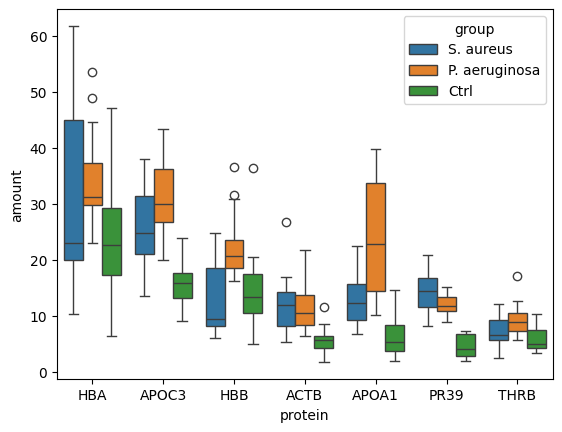

In [ ]:
sns.boxplot(plot_df.merge(design, left_on="sample", right_on="sample"), y="amount", x="protein", hue="group")

In [ ]:
n_peptides_dict = {}
for sample in samples:
    sample_data = data[["Protein", "Peptide", sample]].dropna(subset=[sample])
    protein_dict = {}
    for protein in sample_data["Protein"].unique():
        protein_data = sample_data[sample_data["Protein"] == protein]

        protein_dict[protein] = len(protein_data)
    n_peptides_dict[sample] = protein_dict
n_peptides_dict